# Hot Delivery - Part III
Team 3

## Importing Packages

In [ ]:
!pip install Pulp

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pulp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import datetime


# Initialize seaborn (for plotting)
sns.set()

# Part 3

## Loading and Inspecting Data


In [ ]:
#part3 small

dfOrders3= pd.read_csv("part3_small.csv",index_col=0)
dfOrders3

,customer,estimated availability
restaurant,,
Downtown Toronto (Central Bay Street),North York (Armour Heights / Wilson Heights / ...,2022-04-02 5:17 PM
Downtown Toronto (Christie),West Toronto (Brockton / Parkdale Village / Ex...,2022-04-02 5:49 PM
Downtown Toronto (Ryerson),York (Fairbank / Oakwood),2022-04-02 6:17 PM
Downtown Toronto (St. James Park),East Toronto (The Beaches),2022-04-02 5:53 PM
Downtown Toronto (Kensington Market / Chinatown / Grange Park),Downtown Toronto (Central Bay Street),2022-04-02 5:24 PM


In [ ]:
#part3 drivers

dfDrivers= pd.read_csv("part3_drivers.csv",index_col=0)
dfDrivers

,velocity
start region,
Downtown Toronto (Richmond / Adelaide / King),40
Downtown Toronto (St. James Park),35
Downtown Toronto (Church and Wellesley),32


In [ ]:
# Average Distance between neighborhoods

dfDistance = pd.read_csv("distances.csv")
dfDistance

,origin,destination,distance
0,Scarborough (Malvern / Rouge River),Scarborough (Rouge Hill / Port Union / Highlan...,3.931478
1,Scarborough (Malvern / Rouge River),Scarborough (Guildwood / Morningside / Ellesmere),4.864191
2,Scarborough (Malvern / Rouge River),Scarborough (Woburn),4.778347
3,Scarborough (Malvern / Rouge River),Scarborough (Cedarbrae),6.009861
4,Scarborough (Malvern / Rouge River),Scarborough (Eglinton),7.876162
...,...,...,...
10297,Etobicoke (South Steeles / Silverstone / Humbe...,Etobicoke (Westmount),6.971037
10298,Etobicoke Northwest (Clairville / Humberwood /...,Etobicoke (Westmount),5.185601
10299,Etobicoke (South Steeles / Silverstone / Humbe...,Etobicoke (Kingsview Village / St. Phillips / ...,6.390667
10300,Etobicoke Northwest (Clairville / Humberwood /...,Etobicoke (Kingsview Village / St. Phillips / ...,3.793723


In [ ]:
#regional data

dfRegions = pd.read_csv("regions.csv")
dfRegions

,name,province,code,latitude,longitude
0,Scarborough (Malvern / Rouge River),Ontario,M1B,43.8113,-79.1930
1,Scarborough (Rouge Hill / Port Union / Highlan...,Ontario,M1C,43.7878,-79.1564
2,Scarborough (Guildwood / Morningside / Ellesmere),Ontario,M1E,43.7678,-79.1866
3,Scarborough (Woburn),Ontario,M1G,43.7712,-79.2144
4,Scarborough (Cedarbrae),Ontario,M1H,43.7686,-79.2389
...,...,...,...,...,...
97,Weston,Ontario,M9N,43.7068,-79.5170
98,Etobicoke (Westmount),Ontario,M9P,43.6949,-79.5323
99,Etobicoke (Kingsview Village / St. Phillips / ...,Ontario,M9R,43.6898,-79.5582
100,Etobicoke (South Steeles / Silverstone / Humbe...,Ontario,M9V,43.7432,-79.5876


In [ ]:
regions = list(dfRegions["name"].unique())

distancedictionary = {}
for i in regions:
    for j in regions:
        if i == j:
            distancedictionary[(i,j)] = float(0)
        else: 
            distancedictionary[(i,j)] = float(dfDistance[(dfDistance["origin"] == i)&(dfDistance["destination"] == j)]["distance"])


In [ ]:
distancedictionary

{('Scarborough (Malvern / Rouge River)',
  'Scarborough (Malvern / Rouge River)'): 0.0,
 ('Scarborough (Malvern / Rouge River)',
  'Scarborough (Rouge Hill / Port Union / Highland Creek)'): 3.93147804797437,
 ('Scarborough (Malvern / Rouge River)',
  'Scarborough (Guildwood / Morningside / Ellesmere)'): 4.864190717901831,
 ('Scarborough (Malvern / Rouge River)',
  'Scarborough (Woburn)'): 4.7783471059881615,
 ('Scarborough (Malvern / Rouge River)',
  'Scarborough (Cedarbrae)'): 6.009861121077427,
 ('Scarborough (Malvern / Rouge River)',
  'Scarborough (Eglinton)'): 7.876162326249809,
 ('Scarborough (Malvern / Rouge River)',
  'Scarborough (Kennedy Park / Ionview / East Birchmount Park)'): 10.702192947756066,
 ('Scarborough (Malvern / Rouge River)',
  'Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)'): 13.235830930223024,
 ('Scarborough (Malvern / Rouge River)',
  'Scarborough (Cliffside / Cliffcrest / Scarborough Village West)'): 10.106248580601486,
 ('Scarbo

In [ ]:
#fucntion to calculate time difference in minutes
def getTimeDifference(TimeStart, TimeEnd):
    TimeStart = datetime.datetime.strptime(TimeStart, '%Y-%m-%d %H:%M %p')
    TimeEnd = datetime.datetime.strptime(TimeEnd, '%Y-%m-%d %H:%M %p')
    timeDiff = TimeEnd - TimeStart
    return timeDiff.total_seconds() / 60

### Sets

In [ ]:
#restaurants
restaurants= list(dfOrders3.index)

#customers
customers=list(dfOrders3['customer'])

#number of trips
numtrips=len((customers+restaurants))

#estimated availability for orders
order_availability = [getTimeDifference('2022-04-02 0:00 AM', item) for item in list(dfOrders3['estimated availability'])]

#drivers start region
driversStartRegion =list(dfDrivers.index)

#drivers speed per minute
driversVelocity = list(dfDrivers['velocity'])

#drivers list
drivers = list(range(len(driversStartRegion)))

#restaurant-customer list
rescustlist=driversStartRegion+restaurants+customers

#steps
steps = list(range(1, len(rescustlist)-len(drivers)+1))

#starting points
startarc = list(range(len(drivers), len(rescustlist)))

#ending points
endarc = startarc.copy()

### Variables

In [ ]:
def createPart3Variables():
    """create part 3 varaibles"""
    #variables: if driver v travelling from resteurant i to customer j at step t
    xvar = pulp.LpVariable.dict("x", (drivers + startarc, endarc, drivers, steps), cat=pulp.LpBinary)

    #variable: total travel time at each step for each driver
    dvar = pulp.LpVariable.dict("d", (steps, drivers), cat=pulp.LpContinuous)

    #variable: wait time for each customer 
    wvar = pulp.LpVariable.dict("w", (endarc), cat=pulp.LpContinuous)
    
    return xvar, dvar, wvar

### Model Initialization

In [ ]:
def initializePart3Model():
    """initialize part 3 model"""
    flowModel = pulp.LpProblem(name="Part 3 Solution", sense=pulp.LpMinimize)
    return flowModel

### Constraints

In [ ]:
def createPart3Constraints(flowModel, W):
    """create constraints for part 3 model"""
    #Constraint: every location must be visited by exactly one vehicle
    for j in endarc:
        flowModel+= pulp.lpSum( [xvar[i,j,v,t] for v in drivers for i in ([v] + startarc) for t in steps]) == 1


    #Constraint: conservation of flow (go to node j in step t then start at node j in step t+1) 
    for v in drivers:
        for t in steps[:-1]:
            for j in endarc:
                flowModel += (pulp.lpSum([xvar[(i,j,v,t)]] for i in ([v] + startarc)) == pulp.lpSum([xvar[(j, k, v, t+1)]] for k in endarc))

    # during the first step downtown rosedale has an outflow of 1, others are zero
    # drivers can't all start at step 1 now since there are 3 drivers
    for v in drivers:
        if v == 0:
            flowModel += pulp.lpSum([xvar[(v, j, 0, t)] for j in endarc for t in steps]) == 1
        else:
            flowModel += pulp.lpSum([xvar[(v, j, v, t)] for j in endarc for t in steps]) == 1
            for i in (startarc):
                flowModel += pulp.lpSum([xvar[(i, j, v, 1)]  for j in endarc]) == 0

                
    #Constraint: precedence must occur (must pick up food before dropping off at customer)
    for v in drivers:
        for t in steps:
            for j in endarc:
                if j >= len(drivers + customers): #if arriving at customers' location
                    flowModel += pulp.lpSum(xvar[(i, j, v, t)] for i in ([v] + startarc)) <= pulp.lpSum(xvar[(i, j-len(customers), v, past_t)] for i in ([v] + startarc) for past_t in steps[:t-1])                  

    ## Constraints added for part 2
    #Constraint: the arrival at the first restaurant has timestamp equal to the restaurant's ready time.
    for v in drivers:
        for t in steps:
            flowModel += dvar[t, v] >= pulp.lpSum([order_availability[j-len(drivers)] * xvar[(0,j,v,t)]] for j in endarc if j < len(drivers + customers))

    #set time at each step based on the distance and the speed 40km/h
    for v in drivers:
        for t in steps:
            if t != 1:
                for j in endarc:
                    for i in startarc:
                        if i >= len(drivers + customers):
                            #add 5 mins since leaving from customers
                            flowModel += dvar[t, v] >= (dvar[t-1, v] + pulp.lpSum([distancedictionary[(rescustlist[i],rescustlist[j])] / driversVelocity[v] * 60 * xvar[(i, j, v, t)]]
                                                                  + (5 * xvar[(i,j,v,t)]))) 
                        else:
                            #leave time must be greater than last timestamp + travel time
                            flowModel += dvar[t, v] >= dvar[t-1, v] + pulp.lpSum([distancedictionary[(rescustlist[i],rescustlist[j])] / driversVelocity[v] * 60 * xvar[(i, j, v, t)]])

                            #leave time must be greater than order ready time + travel time
                            flowModel += dvar[t, v] >= pulp.lpSum(xvar[(i,j,v,t)] * order_availability[i-len(drivers)]) + pulp.lpSum([distancedictionary[(rescustlist[i],rescustlist[j])] / driversVelocity[v] * 60 * xvar[(i, j, v, t)]])

    #Constraint: average wating time < W (W=60minuets)
    u = 999999
    for v in drivers:
        for j in endarc:
            if j >= len(drivers + customers):
                for t in steps:
                    for i in ([v] + startarc):
                        flowModel += wvar[j] >= 0
                        flowModel += wvar[j] >= dvar[t, v] - order_availability[(j-len(customers)-len(drivers))] - u*(1 - xvar[(i, j, v, t)])
    #                     flowModel += wvar[j, v] <= dvar[t, v] - order_availability[(j-len(customers)-len(drivers))] + u*(1 - xvar[(i, j, v, t)])

    flowModel += pulp.lpSum([wvar[j] for j in range(len(drivers + customers), len(rescustlist))]) / len(customers) <= W

### Objective

In [ ]:
def addPart3Objective(flowModel):
    """add objetive for part 3 model"""
    objective=0
    for v in drivers:
        for i in ([v] + startarc):
            for j in endarc:
                if i != j:
                    objective += pulp.lpSum([distancedictionary[(rescustlist[i],rescustlist[j])] * xvar[(i, j, v, t)] for t in steps])

    flowModel+=objective

### Run Model

In [ ]:
#set W (tested with different W. When W=20, takes 119s, when W=60, takes 28 seconds)
W = 60

xvar, dvar, wvar = createPart3Variables() #create variables
flowModel = initializePart3Model() #initialize model
createPart3Constraints(flowModel, W) #create constraints
addPart3Objective(flowModel) #add objective

In [ ]:
flowModel.solve(pulp.PULP_CBC_CMD(timeLimit=120))
print("Status:", pulp.LpStatus[flowModel.status])

Status: Optimal


In [ ]:
# Print solution
print("Total distance:" + str(pulp.value(flowModel.objective))+'\n')
wait_times = []

for v in drivers:
    print(f'Driver: {drivers[v] + 1}')
    for t in steps:
        print('step ' + str(t))
        for i in (drivers + startarc):
            for j in endarc:
                if xvar[i,j,v,t].varValue and xvar[i,j,v,t].varValue >= 1.0:
                    if j < len(drivers + customers):
                        if i < len(drivers):
                            print(f'Driving from {rescustlist[v]} To \n{rescustlist[j]} for pickup')
                        else:
                            print(f'Driving from {rescustlist[i]} To \n{rescustlist[j]} for pickup')
                    else:
                        print(f'Driving from {rescustlist[i]} To \n{rescustlist[j]} for delivery') 
                        print(f'Customer wait time is {wvar[j].varValue} minutes')
                        wait_times.append(wvar[j].varValue)
        print()
print(f'Customer average wait time is {sum(wait_times)/len(wait_times)} minutes')

Total distance:30.544085866191324

Driver: 1
step 1

step 2

step 3

step 4

step 5
Driving from Downtown Toronto (Richmond / Adelaide / King) To 
Downtown Toronto (Kensington Market / Chinatown / Grange Park) for pickup

step 6
Driving from Downtown Toronto (Kensington Market / Chinatown / Grange Park) To 
Downtown Toronto (Central Bay Street) for delivery
Customer wait time is 1.4747411 minutes

step 7
Driving from Downtown Toronto (Central Bay Street) To 
Downtown Toronto (Central Bay Street) for pickup

step 8
Driving from Downtown Toronto (Central Bay Street) To 
Downtown Toronto (Ryerson) for pickup

step 9
Driving from Downtown Toronto (Ryerson) To 
York (Fairbank / Oakwood) for delivery
Customer wait time is 10.210002 minutes

step 10
Driving from York (Fairbank / Oakwood) To 
North York (Armour Heights / Wilson Heights / Downsview North) for delivery
Customer wait time is 85.993062 minutes

Driver: 2
step 1

step 2

step 3

step 4

step 5

step 6

step 7

step 8

step 9
Drivin

### Plot for Managerial Question  1 & 2

In [ ]:
W_list = list(range(100, 5, -5))
distances = []
runtime = []

for W in W_list:
    xvar, dvar, wvar = createPart3Variables() #create variables
    flowModel = initializePart3Model() #initialize model
    createPart3Constraints(flowModel, W) #create constraints
    addPart3Objective(flowModel) #add objective
    
    flowModel.solve(pulp.PULP_CBC_CMD(timeLimit=150))
    
    print("W: ", W)
    print("Time elapsed:", flowModel.solutionTime)
    
    if pulp.LpStatus[flowModel.status] == 'Optimal':
        distances.append(pulp.value(flowModel.objective))
        runtime.append(flowModel.solutionTime)
    else:
        distances.append(0)
        runtime.append(0)

Z:\ProgramData\Anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


W:  100
Time elapsed: 31.810470819473267
W:  95
Time elapsed: 43.299765825271606
W:  90
Time elapsed: 34.60949444770813
W:  85
Time elapsed: 31.499629020690918
W:  80
Time elapsed: 36.53051042556763
W:  75
Time elapsed: 35.48865222930908
W:  70
Time elapsed: 34.212493896484375
W:  65
Time elapsed: 31.73593044281006
W:  60
Time elapsed: 37.27394700050354
W:  55
Time elapsed: 36.403197288513184
W:  50
Time elapsed: 32.05687856674194
W:  45
Time elapsed: 35.418720722198486
W:  40
Time elapsed: 31.609844207763672
W:  35
Time elapsed: 35.202749729156494
W:  30
Time elapsed: 43.12241792678833
W:  25
Time elapsed: 53.42455077171326
W:  20
Time elapsed: 150.1652796268463
W:  15
Time elapsed: 150.03179836273193
W:  10
Time elapsed: 149.16827630996704


Z:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


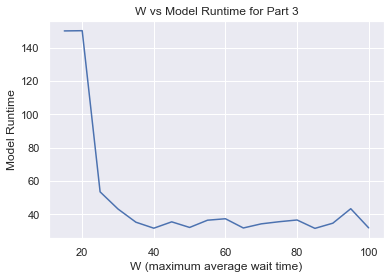

In [ ]:
ax = sns.lineplot(W_list, runtime)
ax.set(xlabel='W (maximum average wait time)', ylabel='Model Runtime')
plt.title("W vs Model Runtime for Part 3")
plt.show()

Z:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


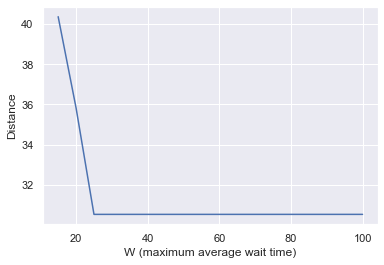

In [ ]:
ax = sns.lineplot(W_list, distances)
ax.set(xlabel='W (maximum average wait time)', ylabel='Distance')
plt.title("W vs Distance for Part 3")
plt.show()

## Part 3 with constraint max wait time <= W for Managerial Question 3

In [ ]:
#update create constraint function
def createPart3Constraints(flowModel, W):
    """create constraints for part 3 model"""
    #Constraint: every location must be visited by exactly one vehicle
    for j in endarc:
        flowModel+= pulp.lpSum( [xvar[i,j,v,t] for v in drivers for i in ([v] + startarc) for t in steps]) == 1


    #Constraint: conservation of flow (go to node j in step t then start at node j in step t+1) 
    for v in drivers:
        for t in steps[:-1]:
            for j in endarc:
                flowModel += (pulp.lpSum([xvar[(i,j,v,t)]] for i in ([v] + startarc)) == pulp.lpSum([xvar[(j, k, v, t+1)]] for k in endarc))

    # during the first step downtown rosedale has an outflow of 1, others are zero
    # drivers can't all start at step 1 now since there are 3 drivers
    for v in drivers:
        if v == 0:
            flowModel += pulp.lpSum([xvar[(v, j, v, 1)] for j in endarc]) == 1
        else:
            flowModel += pulp.lpSum([xvar[(v, j, v, t)] for j in endarc for t in steps]) == 1
        for i in ([v] + startarc):
            flowModel += pulp.lpSum([xvar[(i, j, v, 1)]  for j in endarc]) == 0

    #Constraint: precedence must occur (must pick up food before dropping off at customer)
    for v in drivers:
        for t in steps:
            for j in endarc:
                if j >= len(drivers + customers): #if arriving at customers' location
                    flowModel += pulp.lpSum(xvar[(i, j, v, t)] for i in ([v] + startarc)) <= pulp.lpSum(xvar[(i, j-len(customers), v, past_t)] for i in ([v] + startarc) for past_t in steps[:t-1])                  

    ## Constraints added for part 2
    #Constraint: the arrival at the first restaurant has timestamp equal to the restaurant's ready time.
    for v in drivers:
        for t in steps:
            flowModel += dvar[t, v] >= pulp.lpSum([order_availability[j-len(drivers)] * xvar[(0,j,v,t)]] for j in endarc if j < len(drivers + customers))

    #set time at each step based on the distance and the speed 40km/h
    for v in drivers:
        for t in steps:
            if t != 1:
                for j in endarc:
                    for i in startarc:
                        if i >= len(drivers + customers):
                            #add 5 mins since leaving from customers
                            flowModel += dvar[t, v] >= (dvar[t-1, v] + pulp.lpSum([distancedictionary[(rescustlist[i],rescustlist[j])] / driversVelocity[v] * 60 * xvar[(i, j, v, t)]]
                                                                  + (5 * xvar[(i,j,v,t)]))) 
                        else:
                            #leave time must be greater than last timestamp + travel time
                            flowModel += dvar[t, v] >= dvar[t-1, v] + pulp.lpSum([distancedictionary[(rescustlist[i],rescustlist[j])] / driversVelocity[v] * 60 * xvar[(i, j, v, t)]])

                            #leave time must be greater than order ready time + travel time
                            flowModel += dvar[t, v] >= pulp.lpSum(xvar[(i,j,v,t)] * order_availability[i-len(drivers)]) + pulp.lpSum([distancedictionary[(rescustlist[i],rescustlist[j])] / driversVelocity[v] * 60 * xvar[(i, j, v, t)]])

    #Constraint: average wating time < W (W=60minuets)
    u = 999999
    for v in drivers:
        for j in endarc:
            if j >= len(drivers + customers):
                for t in steps:
                    for i in ([v] + startarc):
                        flowModel += wvar[j] >= 0
                        flowModel += wvar[j] <= W
                        flowModel += wvar[j] >= dvar[t, v] - order_availability[(j-len(customers)-len(drivers))] - u*(1 - xvar[(i, j, v, t)])
    #                     flowModel += wvar[j, v] <= dvar[t, v] - order_availability[(j-len(customers)-len(drivers))] + u*(1 - xvar[(i, j, v, t)])

In [ ]:
W_list = list(range(125, 5, -10))
distances = []
runtime = []

for W in W_list:
    xvar, dvar, wvar = createPart3Variables() #create variables
    flowModel = initializePart3Model() #initialize model
    createPart3Constraints(flowModel, W) #create constraints
    addPart3Objective(flowModel) #add objective
    
    flowModel.solve(pulp.PULP_CBC_CMD(timeLimit=150))
    
    print("W: ", W)
    print("Time elapsed:", flowModel.solutionTime)
    
    if pulp.LpStatus[flowModel.status] == 'Optimal':
        distances.append(pulp.value(flowModel.objective))
        runtime.append(flowModel.solutionTime)
    else:
        distances.append(0)
        runtime.append(0)

Z:\ProgramData\Anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


W:  125
Time elapsed: 32.45437169075012
W:  115
Time elapsed: 27.712729930877686
W:  105
Time elapsed: 22.75153946876526
W:  95
Time elapsed: 28.909459829330444
W:  85
Time elapsed: 115.89524865150452
W:  75
Time elapsed: 118.72172856330872
W:  65
Time elapsed: 148.96036553382874
W:  55
Time elapsed: 116.58796334266663
W:  45
Time elapsed: 148.10782599449158
W:  35
Time elapsed: 149.19229936599731
W:  25
Time elapsed: 148.93884229660034
W:  15
Time elapsed: 148.84532761573792


In [ ]:
distances

[30.544085866191324,
 30.544085866191324,
 30.544085866191324,
 30.544085866191324,
 35.15609681830277,
 35.15609681830277,
 35.15609681830277,
 35.24173449202407,
 35.24173449202407,
 47.209414037276595,
 47.95795297447548,
 0]

Z:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


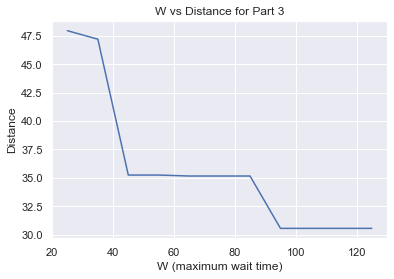

In [ ]:
ax = sns.lineplot(W_list[:-1], distances[:-1])
ax.set(xlabel='W (maximum wait time)', ylabel='Distance')
plt.title("W vs Distance for Part 3")
plt.show()

Z:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


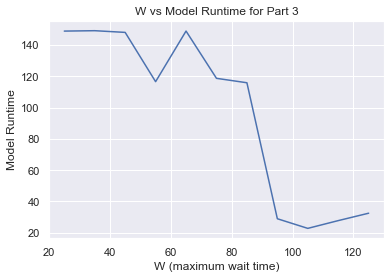

In [ ]:
ax = sns.lineplot(W_list[:-1], runtime[:-1])
ax.set(xlabel='W (maximum wait time)', ylabel='Model Runtime')
plt.title("W vs Model Runtime for Part 3")
plt.show()

### Part 3 for Managerial Question 4

Change the constraints back to W = maximum average wait time

In [ ]:
def createPart3Constraints(flowModel, W):
    """create constraints for part 3 model"""
    #Constraint: every location must be visited by exactly one vehicle
    for j in endarc:
        flowModel+= pulp.lpSum( [xvar[i,j,v,t] for v in drivers for i in ([v] + startarc) for t in steps]) == 1


    #Constraint: conservation of flow (go to node j in step t then start at node j in step t+1) 
    for v in drivers:
        for t in steps[:-1]:
            for j in endarc:
                flowModel += (pulp.lpSum([xvar[(i,j,v,t)]] for i in ([v] + startarc)) == pulp.lpSum([xvar[(j, k, v, t+1)]] for k in endarc))

    # during the first step downtown rosedale has an outflow of 1, others are zero
    # drivers can't all start at step 1 now since there are 3 drivers
    for v in drivers:
        if v == 0:
            flowModel += pulp.lpSum([xvar[(v, j, 0, t)] for j in endarc for t in steps]) == 1
        else:
            flowModel += pulp.lpSum([xvar[(v, j, v, t)] for j in endarc for t in steps]) == 1
            for i in (startarc):
                flowModel += pulp.lpSum([xvar[(i, j, v, 1)]  for j in endarc]) == 0

                
    #Constraint: precedence must occur (must pick up food before dropping off at customer)
    for v in drivers:
        for t in steps:
            for j in endarc:
                if j >= len(drivers + customers): #if arriving at customers' location
                    flowModel += pulp.lpSum(xvar[(i, j, v, t)] for i in ([v] + startarc)) <= pulp.lpSum(xvar[(i, j-len(customers), v, past_t)] for i in ([v] + startarc) for past_t in steps[:t-1])                  

    ## Constraints added for part 2
    #Constraint: the arrival at the first restaurant has timestamp equal to the restaurant's ready time.
    for v in drivers:
        for t in steps:
            flowModel += dvar[t, v] >= pulp.lpSum([order_availability[j-len(drivers)] * xvar[(0,j,v,t)]] for j in endarc if j < len(drivers + customers))

    #set time at each step based on the distance and the speed 40km/h
    for v in drivers:
        for t in steps:
            if t != 1:
                for j in endarc:
                    for i in startarc:
                        if i >= len(drivers + customers):
                            #add 5 mins since leaving from customers
                            flowModel += dvar[t, v] >= (dvar[t-1, v] + pulp.lpSum([distancedictionary[(rescustlist[i],rescustlist[j])] / driversVelocity[v] * 60 * xvar[(i, j, v, t)]]
                                                                  + (5 * xvar[(i,j,v,t)]))) 
                        else:
                            #leave time must be greater than last timestamp + travel time
                            flowModel += dvar[t, v] >= dvar[t-1, v] + pulp.lpSum([distancedictionary[(rescustlist[i],rescustlist[j])] / driversVelocity[v] * 60 * xvar[(i, j, v, t)]])

                            #leave time must be greater than order ready time + travel time
                            flowModel += dvar[t, v] >= pulp.lpSum(xvar[(i,j,v,t)] * order_availability[i-len(drivers)]) + pulp.lpSum([distancedictionary[(rescustlist[i],rescustlist[j])] / driversVelocity[v] * 60 * xvar[(i, j, v, t)]])

    #Constraint: average wating time < W (W=60minuets)
    u = 999999
    for v in drivers:
        for j in endarc:
            if j >= len(drivers + customers):
                for t in steps:
                    for i in ([v] + startarc):
                        flowModel += wvar[j] >= 0
                        flowModel += wvar[j] >= dvar[t, v] - order_availability[(j-len(customers)-len(drivers))] - u*(1 - xvar[(i, j, v, t)])
    #                     flowModel += wvar[j, v] <= dvar[t, v] - order_availability[(j-len(customers)-len(drivers))] + u*(1 - xvar[(i, j, v, t)])

    flowModel += pulp.lpSum([wvar[j] for j in range(len(drivers + customers), len(rescustlist))]) / len(customers) <= W

#### update the set to have 2 drivers

In [ ]:
#restaurants
restaurants= list(dfOrders3.index)

#customers
customers=list(dfOrders3['customer'])

#number of trips
numtrips=len((customers+restaurants))

#estimated availability for orders
order_availability = [getTimeDifference('2022-04-02 0:00 AM', item) for item in list(dfOrders3['estimated availability'])]

#drivers start region
driversStartRegion =list(dfDrivers.index)[0:2]

#drivers speed per minute
driversVelocity = list(dfDrivers['velocity'])[0:2]

#drivers list
drivers = list(range(len(driversStartRegion)))

#restaurant-customer list
rescustlist=driversStartRegion+restaurants+customers

#steps
steps = list(range(1, len(rescustlist)-len(drivers)+1))

#starting points
startarc = list(range(len(drivers), len(rescustlist)))

#ending points
endarc = startarc.copy()

In [ ]:
#set W
W = 60

xvar, dvar, wvar = createPart3Variables() #create variables
flowModel = initializePart3Model() #initialize model
createPart3Constraints(flowModel, W) #create constraints
addPart3Objective(flowModel) #add objective

flowModel.solve(pulp.PULP_CBC_CMD(timeLimit=120))
print("Status:", pulp.LpStatus[flowModel.status])

Status: Optimal


In [ ]:
# Print solution
print("Total distance:" + str(pulp.value(flowModel.objective))+'\n')
wait_times = []

for v in drivers:
    print(f'Driver: {drivers[v] + 1}')
    for t in steps:
        print('step ' + str(t))
        for i in (drivers + startarc):
            for j in endarc:
                if xvar[i,j,v,t].varValue and xvar[i,j,v,t].varValue >= 1.0:
                    if j < len(drivers + customers):
                        if i < len(drivers):
                            print(f'Driving from {rescustlist[v]} To \n{rescustlist[j]} for pickup')
                        else:
                            print(f'Driving from {rescustlist[i]} To \n{rescustlist[j]} for pickup')
                    else:
                        print(f'Driving from {rescustlist[i]} To \n{rescustlist[j]} for delivery') 
                        print(f'Customer wait time is {wvar[j].varValue} minutes')
                        wait_times.append(wvar[j].varValue)
        print()
print(f'Customer average wait time is {sum(wait_times)/len(wait_times)} minutes')

Total distance:30.183624560233127

Driver: 1
step 1

step 2

step 3
Driving from Downtown Toronto (Richmond / Adelaide / King) To 
Downtown Toronto (Kensington Market / Chinatown / Grange Park) for pickup

step 4
Driving from Downtown Toronto (Kensington Market / Chinatown / Grange Park) To 
Downtown Toronto (Central Bay Street) for delivery
Customer wait time is 1.4747411 minutes

step 5
Driving from Downtown Toronto (Central Bay Street) To 
Downtown Toronto (Central Bay Street) for pickup

step 6
Driving from Downtown Toronto (Central Bay Street) To 
Downtown Toronto (Ryerson) for pickup

step 7
Driving from Downtown Toronto (Ryerson) To 
Downtown Toronto (Christie) for pickup

step 8
Driving from Downtown Toronto (Christie) To 
West Toronto (Brockton / Parkdale Village / Exhibition Place) for delivery
Customer wait time is 38.554154 minutes

step 9
Driving from West Toronto (Brockton / Parkdale Village / Exhibition Place) To 
York (Fairbank / Oakwood) for delivery
Customer wait time

#### update the set to have only 1 driver

In [ ]:
#restaurants
restaurants= list(dfOrders3.index)

#customers
customers=list(dfOrders3['customer'])

#number of trips
numtrips=len((customers+restaurants))

#estimated availability for orders
order_availability = [getTimeDifference('2022-04-02 0:00 AM', item) for item in list(dfOrders3['estimated availability'])]

#drivers start region
driversStartRegion =list(dfDrivers.index)[0:1]

#drivers speed per minute
driversVelocity = list(dfDrivers['velocity'])[0:1]

#drivers list
drivers = list(range(len(driversStartRegion)))

#restaurant-customer list
rescustlist=driversStartRegion+restaurants+customers

#steps
steps = list(range(1, len(rescustlist)-len(drivers)+1))

#starting points
startarc = list(range(len(drivers), len(rescustlist)))

#ending points
endarc = startarc.copy()

In [ ]:
#set W
W = 60

xvar, dvar, wvar = createPart3Variables() #create variables
flowModel = initializePart3Model() #initialize model
createPart3Constraints(flowModel, W) #create constraints
addPart3Objective(flowModel) #add objective

flowModel.solve(pulp.PULP_CBC_CMD(timeLimit=120))
print("Status:", pulp.LpStatus[flowModel.status])

Status: Optimal


In [ ]:
# Print solution
print("Total distance:" + str(pulp.value(flowModel.objective))+'\n')
wait_times = []

for v in drivers:
    print(f'Driver: {drivers[v] + 1}')
    for t in steps:
        print('step ' + str(t))
        for i in (drivers + startarc):
            for j in endarc:
                if xvar[i,j,v,t].varValue and xvar[i,j,v,t].varValue >= 1.0:
                    if j < len(drivers + customers):
                        if i < len(drivers):
                            print(f'Driving from {rescustlist[v]} To \n{rescustlist[j]} for pickup')
                        else:
                            print(f'Driving from {rescustlist[i]} To \n{rescustlist[j]} for pickup')
                    else:
                        print(f'Driving from {rescustlist[i]} To \n{rescustlist[j]} for delivery') 
                        print(f'Customer wait time is {wvar[j].varValue} minutes')
                        wait_times.append(wvar[j].varValue)
        print()
print(f'Customer average wait time is {sum(wait_times)/len(wait_times)} minutes')

Total distance:37.175909688749634

Driver: 1
step 1
Driving from Downtown Toronto (Richmond / Adelaide / King) To 
Downtown Toronto (St. James Park) for pickup

step 2
Driving from Downtown Toronto (St. James Park) To 
East Toronto (The Beaches) for delivery
Customer wait time is 10.822594 minutes

step 3
Driving from East Toronto (The Beaches) To 
Downtown Toronto (Ryerson) for pickup

step 4
Driving from Downtown Toronto (Ryerson) To 
Downtown Toronto (Kensington Market / Chinatown / Grange Park) for pickup

step 5
Driving from Downtown Toronto (Kensington Market / Chinatown / Grange Park) To 
Downtown Toronto (Central Bay Street) for pickup

step 6
Driving from Downtown Toronto (Central Bay Street) To 
Downtown Toronto (Central Bay Street) for delivery
Customer wait time is 59.463193 minutes

step 7
Driving from Downtown Toronto (Central Bay Street) To 
Downtown Toronto (Christie) for pickup

step 8
Driving from Downtown Toronto (Christie) To 
West Toronto (Brockton / Parkdale Villa